* Student Name: Mya Hnin Si
* Student ID: C0922606

# Data Loading and Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Define dataset paths
train_dir = "dataset/seg_train"
test_dir = "dataset/seg_test"

In [3]:
# Define image size and batch size
img_size = (128, 128)
batch_size = 32

# Define class names
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Create ImageDataGenerator for training and testing
train_datagen = ImageDataGenerator(
    rescale=1.0/255, # Normalize pixel values to [0, 1]
    validation_split=0.2  # 20% validation split
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Create generators for training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size, # Resize images
    batch_size=batch_size, # Set batch size
    class_mode='categorical', # Use categorical for multi-class classification
    subset="training"
)


# Create generators for validation data
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation"
)

# Create generators for test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [5]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

Training samples: 11230
Validation samples: 2804


In [6]:
# Verify images and labels shapes
images, labels = next(train_generator)
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (32, 128, 128, 3)
Labels shape: (32, 6)


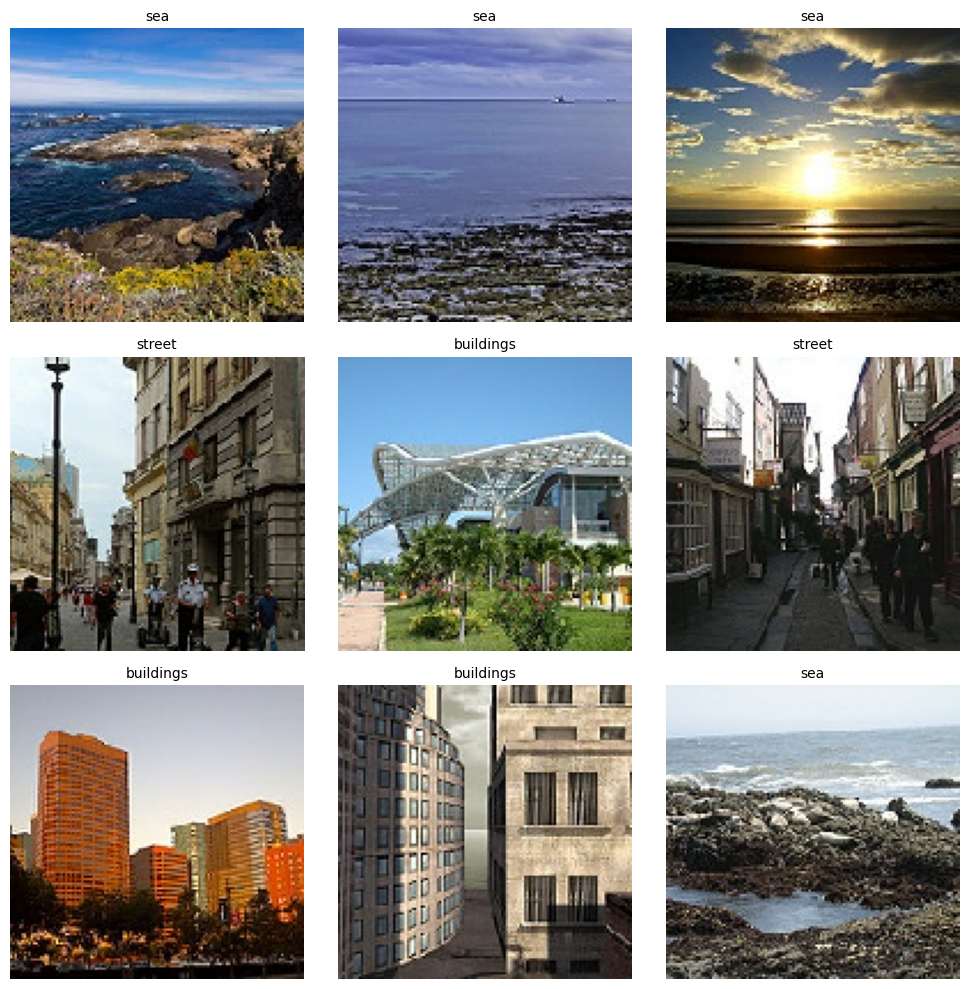

In [7]:
# Display a few images with their corresponding labels
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i])
        class_index = labels[i].argmax()
        ax.set_title(f"{class_names[class_index]}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Model Building 

### Create a CNN architecture with the following layers:
* Input Layer: Appropriate shape for the image data
* Convolutional Layers: At least 2 convolution layers with ReLU activation
* Pooling Layers: Use MaxPooling for downsampling
* Dropout Layer: To prevent overfitting
* Flatten and Dense Layers: To connect to the output
* Output Layer: Use Softmax activation for classification

In [8]:
# Define the model with an explicit Input layer
model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(), # # Flatten Layer 
    Dense(128, activation='relu'),
    Dropout(0.5), # Dropout Layer to prevent overfitting
    Dense(6, activation='softmax') # Output Layer
])

# Print model summary
model.summary()

c:\Users\Home\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,094 (28.20 MB)

 Trainable params: 7,393,094 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model using:
* Loss Function: categorical_crossentropy
* Optimizer: adam or sgd
* Metrics: accuracy


In [9]:
# Define Adam optimizer
adam = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Training

### Train the model using training set and use validation split for performance monitoring

In [10]:
# EarlyStopping to stop training when val_loss stops improving
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Save the best model during training
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)

c:\Users\Home\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 232s 647ms/step - accuracy: 0.4909 - loss: 1.3375 - val_accuracy: 0.6669 - val_loss: 0.8596
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 200s 571ms/step - accuracy: 0.6732 - loss: 0.8519 - val_accuracy: 0.7407 - val_loss: 0.7086
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 167s 475ms/step - accuracy: 0.7560 - loss: 0.6888 - val_accuracy: 0.7714 - val_loss: 0.6357
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 111s 315ms/step - accuracy: 0.7930 - loss: 0.5761 - val_accuracy: 0.7924 - val_loss: 0.6013
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 181s 516ms/step - accuracy: 0.8405 - loss: 0.4508 - val_accuracy: 0.7967 - val_loss: 0.6079
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 196s 560ms/step - accuracy: 0.8755 - loss: 0.3409 - val_accuracy: 0.7764 - val_loss: 0.7186


### Display the accuracy and loss graphs

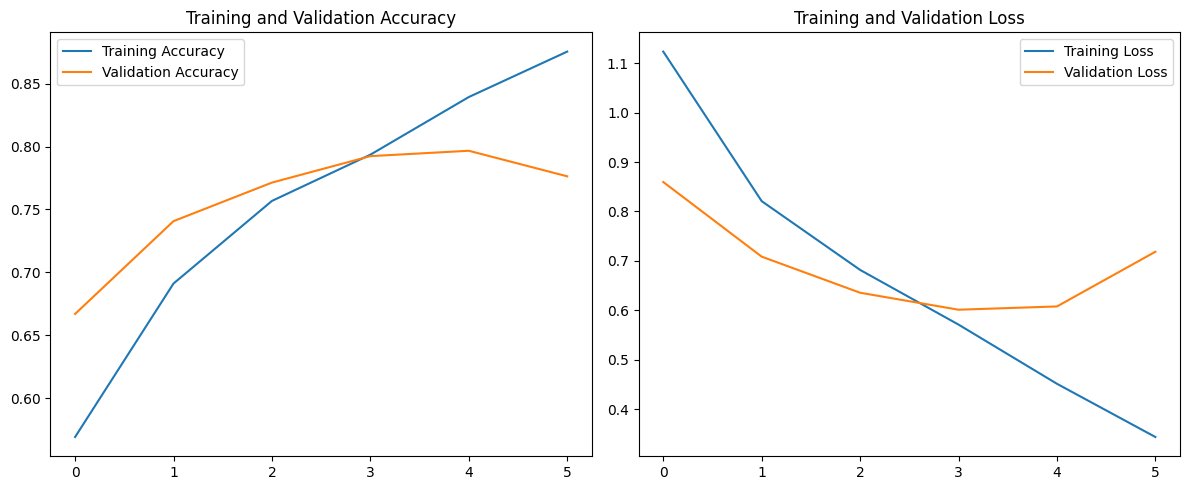

In [11]:
# Display the accuracy and loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot accuracy graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Show the plots
plt.tight_layout()
plt.show()

Findings

* In the initial CNN model, training accuracy keeps improving, but validation accuracy stalls. The widening gap between them shows overfitting, meaning the model is learning the training data too well but failing to generalize.

* This is also confirmed by the loss trend. Training loss decreases as expected, but validation loss starts creeping up. This means the model is memorizing patterns instead of truly learning, leading to poor performance on unseen data.

# Model Evaluation

### Evaluate the model on the testing set

In [12]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 320ms/step - accuracy: 0.7865 - loss: 0.6193
Test Accuracy: 0.7903
Test Loss: 0.6072


### Display accuracy, precision, recall, and F1-score

In [13]:
# Get the true labels from test generator
y_true = test_generator.classes

# Get predicted probabilities
y_pred_probs = model.predict(test_generator)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Generate classification report
class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", class_report)

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step
Classification Report:
               precision    recall  f1-score   support

   buildings       0.12      0.15      0.13       437
      forest       0.14      0.14      0.14       474
     glacier       0.20      0.19      0.20       553
    mountain       0.20      0.20      0.20       525
         sea       0.14      0.12      0.13       510
      street       0.19      0.17      0.18       501

    accuracy                           0.16      3000
   macro avg       0.16      0.16      0.16      3000
weighted avg       0.17      0.16      0.16      3000



### Generate a confusion matrix and visualize it using matplotlib

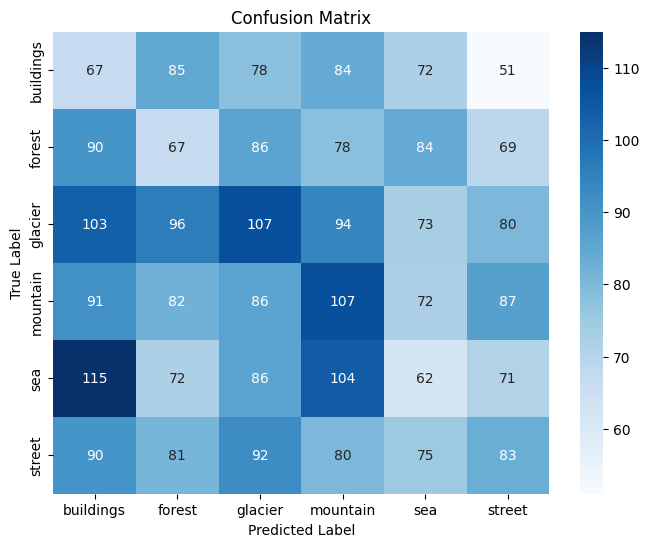

In [14]:
# Generate a confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Visualization and Interpretation 

### Display a few misclassified images

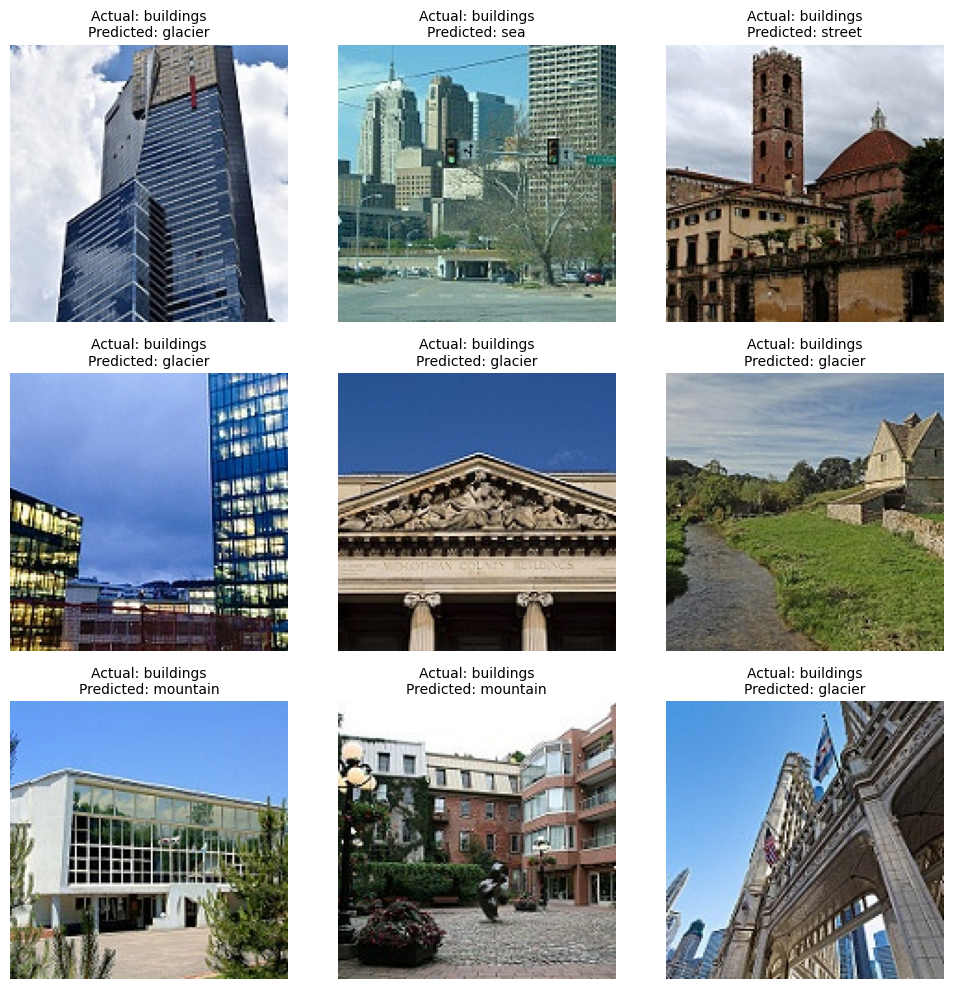

In [15]:
# Get misclassified indices
misclassified_indices = np.nonzero(y_pred_classes != y_true)[0]

# Display a few misclassified images
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < len(misclassified_indices):
        index = misclassified_indices[i]
        image_path = test_generator.filepaths[index]
        image = plt.imread(image_path)
        true_label = class_names[y_true[index]]
        pred_label = class_names[y_pred_classes[index]]
        ax.imshow(image)
        ax.set_title(f"Actual: {true_label}\nPredicted: {pred_label}", fontsize=10)
    ax.axis("off")

# Show the plots
plt.tight_layout()
plt.show()

### Plot feature maps of the first convolution layer to visualize how the CNN extracts features

In [16]:
# Get one batch from your test generator
x_batch, y_batch = next(test_generator)

# Pick a sample image from the batch
sample_image = np.expand_dims(x_batch[0], axis=0)
print(sample_image.shape)

(1, 128, 128, 3)


In [17]:
# Ensure the model is built
model.build()

# Get the outputs of all convolutional layers
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]

# Create a new model that maps the input to these outputs
activation_model = Model(inputs=model.layers[0].input, outputs=layer_outputs)

In [18]:
# Get the feature maps for the sample image
feature_maps = activation_model.predict(sample_image)

# Get the first convolutional layer output
first_layer_output = feature_maps[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


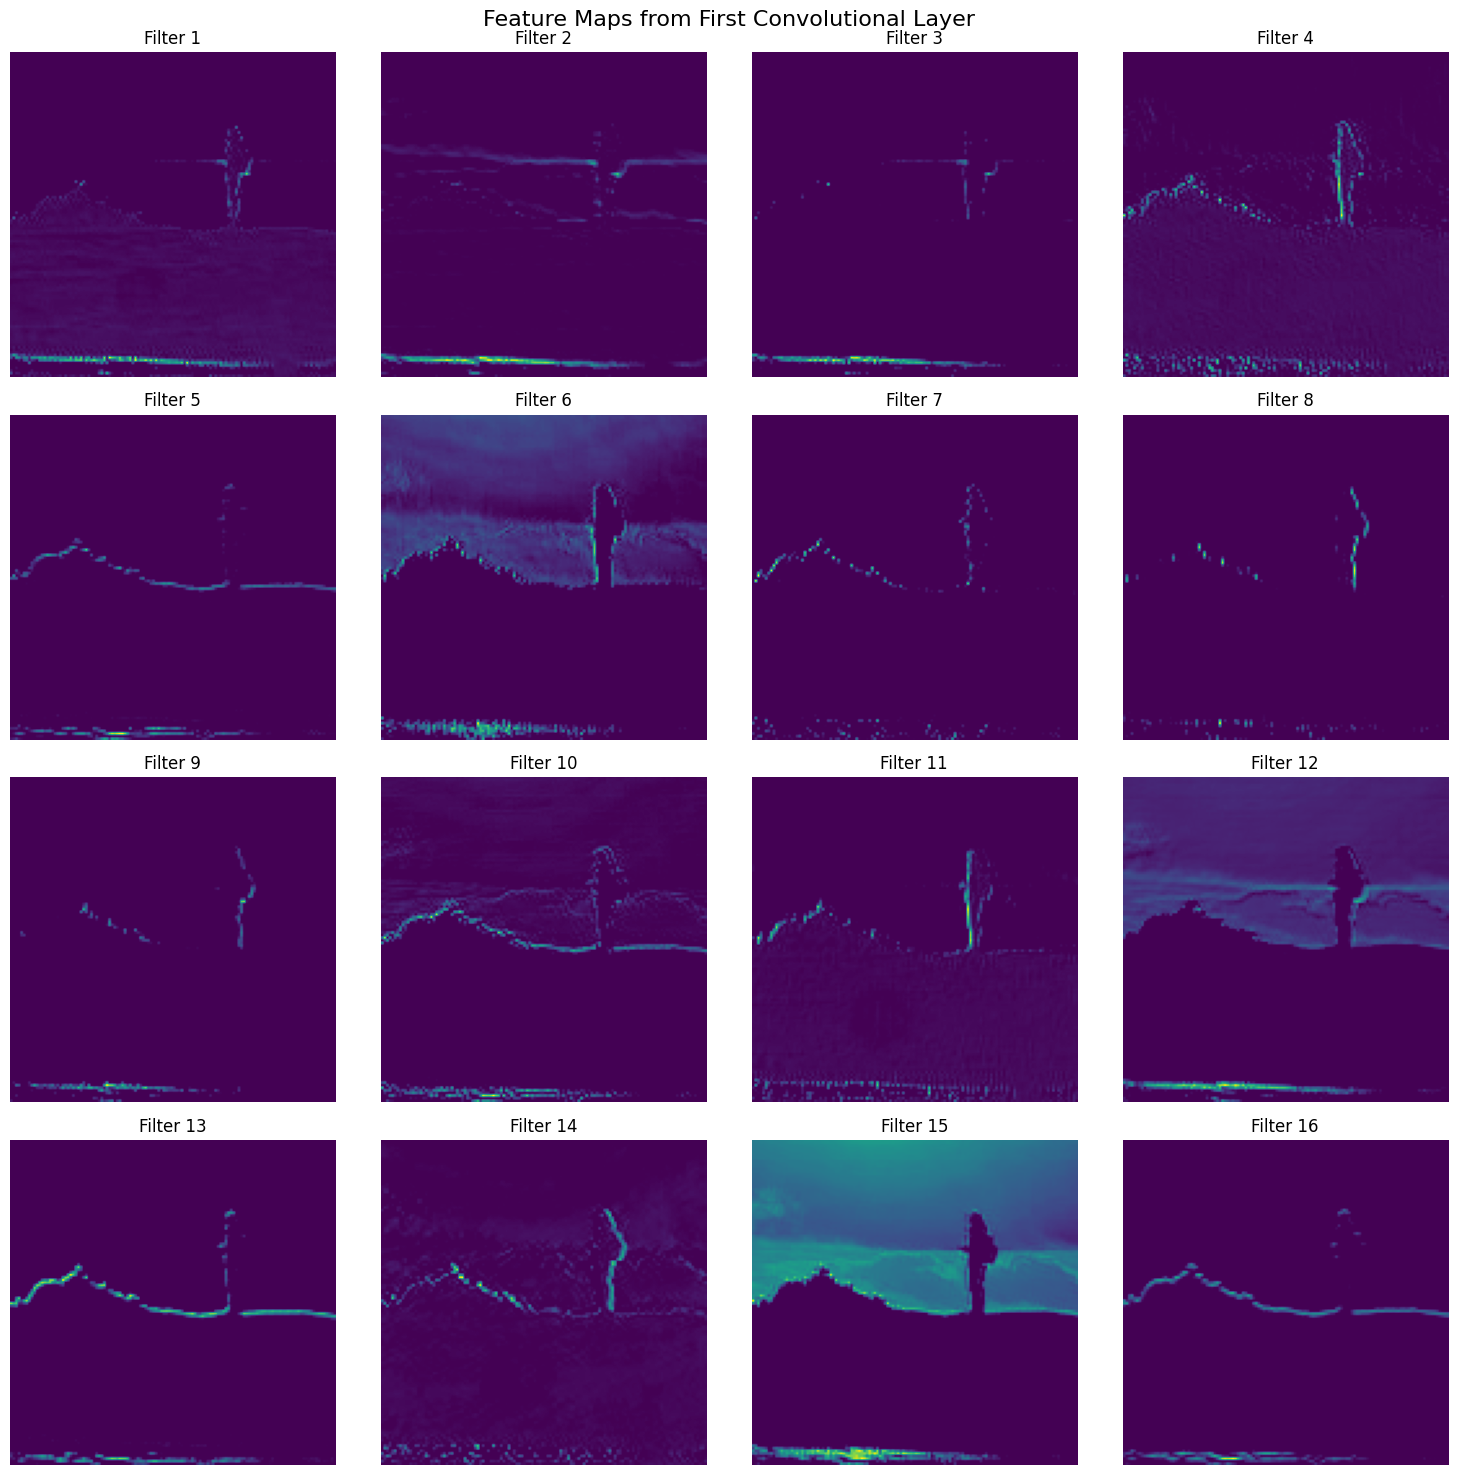

In [19]:
# Plot the feature maps
num_filters = first_layer_output.shape[-1]

plt.figure(figsize=(15, 15))
for i in range(min(num_filters, 16)):  # Limit to 16 filters for readability
    plt.subplot(4, 4, i+1)
    plt.imshow(first_layer_output[0, :, :, i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Filter {i+1}')
plt.suptitle('Feature Maps from First Convolutional Layer', fontsize=16)
plt.tight_layout()
plt.show()

### Include a brief explanation of the model’s performance and areas for improvement

Model Performance Summary
The model reached about 87.5% accuracy on the training data, and around 79.6% on validation, which is pretty close to the 79% accuracy it got on the test set. This means the model was able to generalize fairly well to new data.

Looking at the training and validation curves, both improved steadily until around epoch 4 or 5. After that, validation accuracy stopped improving and even dropped a bit. It is a sign that the model was starting to overfit.

Even though the overall accuracy was decent, the classification report showed a problem: precision, recall, and F1-scores were all low (around 0.12 to 0.20) for each class. This tells us the model had trouble telling the classes apart. Possible reasons could be:

- Some classes may have had more data than others (class imbalance)

- Some categories might look very similar (scene confusion, like glacier vs. mountain)

- The model might just be too simple to handle the complexity of the dataset

The confusion matrix confirmed this and it showed lots of misclassifications. And, when looking at misclassified images, it was clear the model struggled with certain scenes, which matched what the numbers were showing.

Areas for Improvement
1. Model Complexity
Current CNN has only 2 Conv layers. Adding another convolutional block or experimenting with pre-trained models like VGG16, ResNet could help the model learn more detailed features.

2. Data Augmentation
Using stronger augmentations like rotations, zoom, flips, brightness changes during training may improve generalization and reduce overfitting.

3. Class Imbalance Handling
Investigate class distribution. If imbalance exists, try:
- Class weights
- Oversampling/undersampling

Even though the model’s overall accuracy was decent, it didn’t do well on individual classes. That means it’s not fully learning to separate each category clearly. With some tuning and improvements, it could get a lot better.